In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scIB

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.20.4 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Ignore R warning messages
import rpy2.robjects as ro
import anndata2ri

In [4]:
a = ro.r(".libPaths()")

In [6]:
list(a)

['/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/R/library']

In [3]:
plt.rcParams['figure.figsize'] = 8,8

In [4]:
#facs = "../data/01Preprocessing_FACS_preprocessed.h5ad"
#adata_facs = sc.read(facs, cache=True)
#sc.pp.subsample(adata_facs, fraction=0.3)
adata_facs = sc.read("../data/tabula_muris/facs_trunc.h5ad")

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02.89) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:08.05) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.13) --> found 12 clusters and added
    'louvain_post', the cluster labels (adata.obs, categorical)


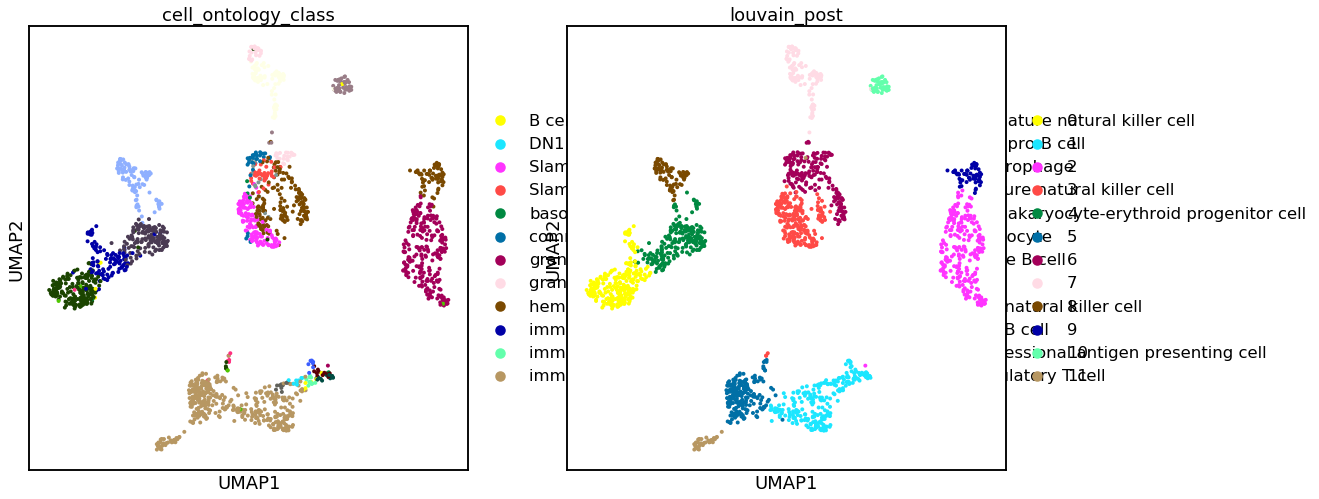

In [5]:
scIB.preprocessing.reduce_data(adata_facs, hvg=False, pca=False, umap=True)
sc.tl.louvain(adata_facs, resolution=0.5, key_added='louvain_post')

sc.pl.umap(adata_facs, color=['cell_ontology_class', 'louvain_post'], palette=sc.pl.palettes.godsnot_64)

In [7]:
adata_facs.write("../data/tabula_muris/facs_trunc.h5ad")

## kBET

In [ ]:
ro.pandas2ri.activate()

In [8]:
adata_facs

AnnData object with n_obs × n_vars = 1898 × 16635 
    obs: 'barcode', 'batch', 'cell_ontology_class', 'log_counts', 'method', 'mt_frac', 'n_counts', 'n_genes', 'sample', 'sex', 'tissue', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_post'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_ontology_class_colors', 'diffmap_evals', 'draw_graph', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'sex_colors', 'tissue_colors', 'louvain', 'louvain_post_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'counts'

In [9]:
ro.r("library(kBET)")
ro.globalenv['data_mtrx'] = adata_facs.X
ro.globalenv['batch'] = adata_facs.obs['S_score']
batch_estimate = ro.r("batch.estimate <- kBET(data_mtrx, batch)")
batch_estimate

In [13]:
ro.pandas2ri.deactivate()

## PC Regression

In [5]:
adata = adata_facs

In [6]:
scIB.metrics.pcr_comparison(adata, adata.layers['counts'], adata.X)

0.316471519092547

In [8]:
ro.pandas2ri.activate()

In [9]:
pca_data = ro.r("pca.data <- prcomp(data_mtrx, center=TRUE)")
pca_data

sdev,[RTYPES.REALSXP]
rotation,[RTYPES.REALSXP]
center,[RTYPES.REALSXP]
scale,[RTYPES.LGLSXP]
x,[RTYPES.REALSXP]


In [10]:
# ro.r("batch.silhouette <- batch_sil(pca.data, batch)")
pcr = ro.r("batch.pca <- pcRegression(pca.data, batch, n_top=100)")

In [11]:
pca_regression = dict(zip(pcr.names, list(pcr)))
pca_regression

{'maxVar': array([8.6, 1.8, 1.4, 0.4, 0.2]),
 'PmaxVar': array([1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16]),
 'pcNfrac': array([0.15]),
 'pcRegscale': array([0.66013072]),
 'maxCorr': array([0.69990036]),
 'maxR2': array([0.48986052]),
 'msigPC': array([1.]),
 'maxsigPC': array([1.]),
 'R2Var': array([0.04931411]),
 'ExplainedVar': array([8.6, 4.9, 1.8, ..., 0. , 0. , 0. ]),
 'r2': array([[4.89860518e-01, 1.00000000e-16, 1.00000000e-16],
        [2.30883094e-02, 6.69618509e-11, 2.44288598e-10],
        [7.71205546e-02, 1.00000000e-16, 1.00000000e-16],
        ...,
        [6.59563002e-04, 7.89010164e-01, 5.35185359e-01],
        [1.82339878e-04, 7.75358794e-01, 8.41320341e-01],
        [6.36993474e-04, 2.81182451e-01, 5.46760931e-01]])}

In [12]:
pca_regression['pcRegscale'][0]

0.6601307189542484

In [13]:
ro.pandas2ri.deactivate()